inspired by:

https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import textwrap
import langid



In [2]:
import nltk

# Force re-download the punkt resource
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Check all available resources and their locations
print(nltk.data.path)

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


['/Users/juliuseg/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/share/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Airbnb Dataset

In [3]:
# Read in data
df_full = pd.read_csv('data/reviews_airbnb.csv') # https://www.kaggle.com/datasets/nikitaryabukhin/reviewshotel?select=reviews_hotel1.csv
print(df_full.shape)
# Drop nan reviews
# df_full = df_full[df_full['reviews.text'].notna()]
df = df_full.head(5000)
print(df.shape)


(429465, 6)
(5000, 6)


In [4]:
# Prune language of dataframe
df = df[df["comments"].apply(lambda x: langid.classify(str(x))[0] == "en")]

In [5]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
1,1312191,6852815,2013-08-27,4989227,Sasu,"Great house, great people renting it. Highly r..."
2,1312191,14022265,2014-06-10,8004355,Rosie,"Catrine is very lovely, helpful and stayed in ..."
3,1312191,82220825,2016-06-26,53892649,Dennis,Nice appartment. Catrine was very helpfull dur...
4,1312191,92695262,2016-08-09,37491893,Julie,7 of us stayed at the home. We ate most meals...
5,1312191,93469920,2016-08-12,8732262,Sabine,"The location of the house is perfect, it only ..."


In [6]:

# Rename the colomns for easier data replacement:
df.rename(columns={'comments': 'Review'}, inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,Review
1,1312191,6852815,2013-08-27,4989227,Sasu,"Great house, great people renting it. Highly r..."
2,1312191,14022265,2014-06-10,8004355,Rosie,"Catrine is very lovely, helpful and stayed in ..."
3,1312191,82220825,2016-06-26,53892649,Dennis,Nice appartment. Catrine was very helpfull dur...
4,1312191,92695262,2016-08-09,37491893,Julie,7 of us stayed at the home. We ate most meals...
5,1312191,93469920,2016-08-12,8732262,Sabine,"The location of the house is perfect, it only ..."


In [7]:
example = df['Review'][1]
print(example)

Great house, great people renting it. Highly recommended!


### Tokens

In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Great',
 'house',
 ',',
 'great',
 'people',
 'renting',
 'it',
 '.',
 'Highly',
 'recommended']

In [9]:
tagged = nltk.pos_tag(tokens) # See meanings here https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tagged[:10]

[('Great', 'NNP'),
 ('house', 'NN'),
 (',', ','),
 ('great', 'JJ'),
 ('people', 'NNS'),
 ('renting', 'VBG'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Highly', 'NNP'),
 ('recommended', 'VBD')]

### Dictionary approach (VADER)

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [11]:
temp = sia.polarity_scores(example)
print (example)
print (temp)

Great house, great people renting it. Highly recommended!
{'neg': 0.0, 'neu': 0.321, 'pos': 0.679, 'compound': 0.8906}


In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    # if text is float print the index and the text
    if isinstance(text, float):
        print(row['id'], text)
        continue
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

print(len(res))



  0%|          | 0/4007 [00:00<?, ?it/s]

4007


In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
merged = vaders.merge(df, on='id', how='left')

### Pretrained transformer model (Roberta)

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [15]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Because im using my mac m2 where metal is gpu framework (Like cuda for nvidia)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [16]:
# VADER results on example for comparison
print(example)
print(sia.polarity_scores(example))

# Roberta
# Tokenize and move tensors to the same device as model
encoded_text = tokenizer(example, return_tensors="pt")
encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

# Run inference safely on MPS
with torch.no_grad():
    output = model(**encoded_text)

# Move result to CPU for numpy operations
scores = output.logits[0].to("cpu").numpy()
scores = softmax(scores)

scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print({k: round(float(v), 3) for k, v in scores_dict.items()})

Great house, great people renting it. Highly recommended!
{'neg': 0.0, 'neu': 0.321, 'pos': 0.679, 'compound': 0.8906}
{'roberta_neg': 0.002, 'roberta_neu': 0.012, 'roberta_pos': 0.986}


#### Function to use to do entire dataset

In [17]:
def polarity_scores_roberta(example):
    # Tokenize and move to correct device
    encoded_text = tokenizer(example, return_tensors="pt")
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Inference
    with torch.no_grad():
        output = model(**encoded_text)

    # Move back to CPU for numpy conversion
    scores = output.logits[0].to("cpu").numpy()
    scores = softmax(scores)

    # Convert to normal floats
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [18]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        # if text is float print the index and the text
        if isinstance(text, float):
            print("Skipped float value on: ",row['id'], text)
            continue
        myid = row['id']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4007 [00:00<?, ?it/s]

Broke for id 584507872
Broke for id 56143435


In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')
results_df.columns


Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'listing_id', 'date',
       'reviewer_id', 'reviewer_name', 'Review'],
      dtype='object')

### Plot output

/var/folders/lc/hb2ry3c568xg7y9qdybnfm280000gn/T/ipykernel_10574/3096328673.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')


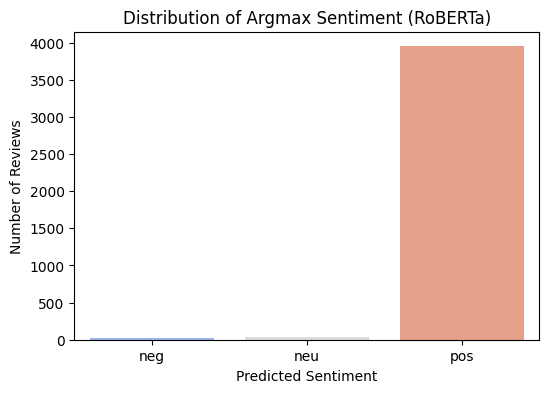

roberta_argmax
neg      18
neu      35
pos    3952
Name: count, dtype: int64


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine argmax label per row
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
results_df['roberta_argmax'] = results_df[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)

# Count and plot
counts = results_df['roberta_argmax'].value_counts().reindex(['neg', 'neu', 'pos'])

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')
plt.title('Distribution of Argmax Sentiment (RoBERTa)')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# Print counts
print(counts)


### Word clouds

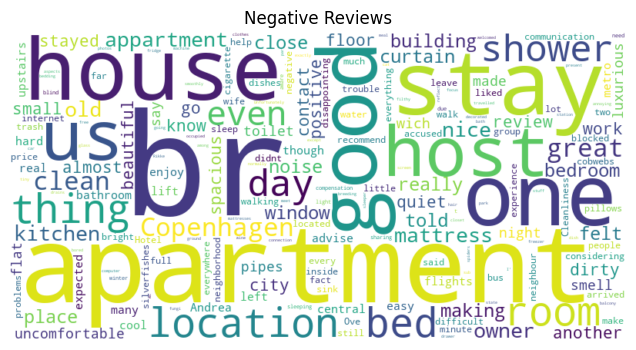

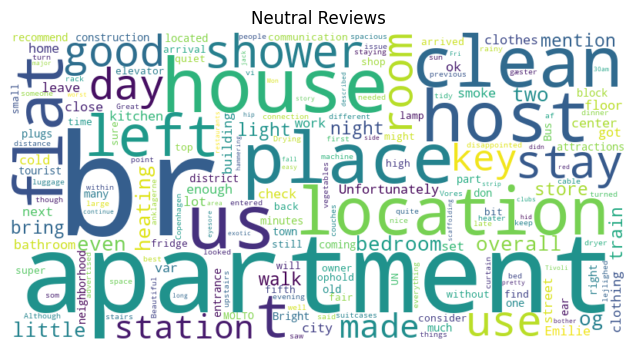

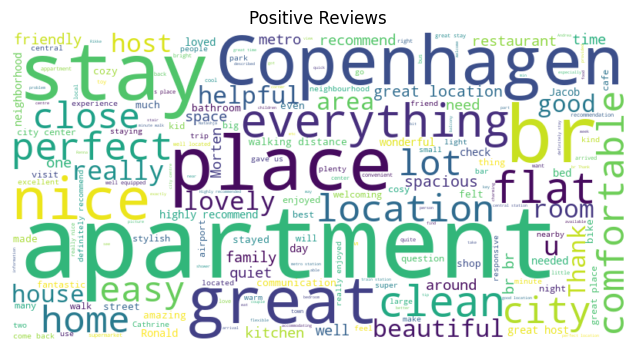

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Determine which sentiment dominates
results_df["roberta_label"] = results_df[["roberta_neg", "roberta_neu", "roberta_pos"]].idxmax(axis=1)

# Combine all text for each sentiment
neg_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_neg", "Review"].astype(str))
neu_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_neu", "Review"].astype(str))
pos_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_pos", "Review"].astype(str))

# Helper function
def make_wc(text, title):
    wc = WordCloud(width=800, height=400, background_color="white", stopwords=None).generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create 3 word clouds
make_wc(neg_text, "Negative Reviews")
make_wc(neu_text, "Neutral Reviews")
make_wc(pos_text, "Positive Reviews")


### Weight by how much more they appear in postive than negative

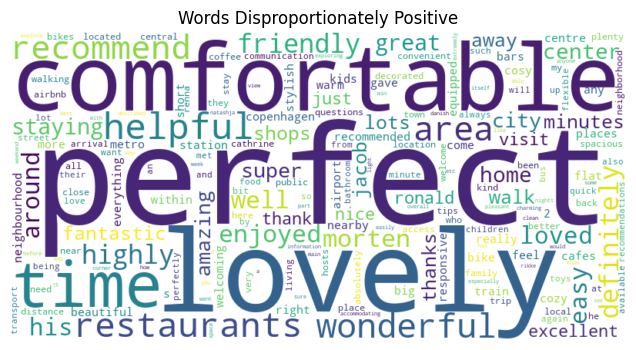

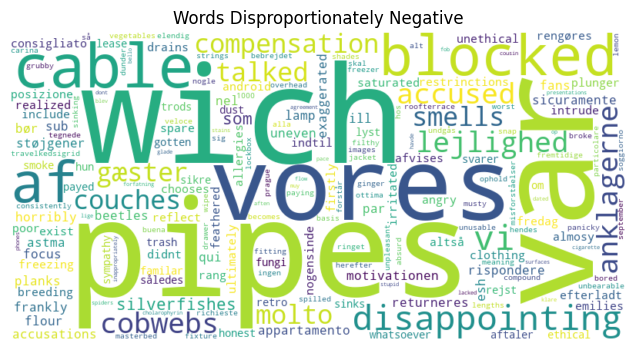

In [23]:
from collections import Counter
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def make_weighted_wc(group1_texts, group2_texts, title):
    # Count words
    c1 = Counter(token for text in group1_texts for token in tokenize(str(text)))
    c2 = Counter(token for text in group2_texts for token in tokenize(str(text)))

    # Compute weighted ratio
    weights = {}
    for w in set(c1.keys()) | set(c2.keys()):
        a, b = c1[w], c2[w]
        weights[w] = a / max(b, 1)  # avoid divide-by-zero

    # Build word cloud from weighted frequencies
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(weights)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example usage
pos_texts = results_df.loc[results_df.roberta_neg < results_df.roberta_pos, "Review"]
neg_texts = results_df.loc[results_df.roberta_pos < results_df.roberta_neg, "Review"]

make_weighted_wc(pos_texts, neg_texts, "Words Disproportionately Positive")
make_weighted_wc(neg_texts, pos_texts, "Words Disproportionately Negative")
